In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from statannotations.Annotator import Annotator

In [2]:
# Save to
outpath = '../../results/CharacterizationOfQuantseqGroups/Expression'
os.makedirs(outpath, exist_ok=True)

In [3]:
# Import gene-groups
dfQuantseq = pd.read_csv(
    '../../results/GeneGroups_Quantseq/3UtrLoci/QuantseqGroups.bed', header=None, sep='\t'
    )

# Import TPMs (gene sum)
DfTpm = pd.read_csv('../../data/MihaDeseq/GeneLevel_TPM_counts.csv', index_col=0)
# Get condition means
conditions = []
colnames = []
for c in DfTpm.columns:
    cond = '_'.join([c.split('_')[el] for el in [0, 2]])
    colnames.append(f'{cond}.{c}')
    conditions.append(cond)
conditions = sorted(set(conditions))
DfTpm.columns = colnames

DfTpmAveraged = pd.DataFrame()
for cond in conditions:
    DfTpmAveraged[f'{cond} Mean TPM'] = DfTpm[[c for c in DfTpm.columns if c.split('.')[0] == cond]].mean(axis='columns')
DfTpmAveraged.head()

,KO_2iL Mean TPM,KO_FCL Mean TPM,S200A_2iL Mean TPM,S200A_FCL Mean TPM,S200WT_2iL Mean TPM,S200WT_FCL Mean TPM,WT_2iL Mean TPM,WT_FCL Mean TPM
stable_gene_id,,,,,,,,
ENSMUSG00000000001,6.677950,7.112323,5.880970,5.033886,7.122433,1.797935,3.333492,2.864102
ENSMUSG00000000003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSMUSG00000000028,10.692164,8.045459,9.775650,6.133840,13.348023,3.322841,14.107630,6.196186
ENSMUSG00000000031,0.093472,0.000000,0.062915,0.569452,0.000000,0.000000,0.000000,0.178639
ENSMUSG00000000037,0.144660,0.038239,0.305144,0.137961,0.196149,0.249172,0.057581,0.086607


In [4]:
dfQuantseq = dfQuantseq.merge(DfTpmAveraged, left_on=6, right_index=True, how='left')

In [5]:
dfQuantseq = dfQuantseq.melt(
    id_vars=[c for c in dfQuantseq.columns.tolist() if ' Mean TPM' not in str(c)],
    value_vars=[c for c in dfQuantseq.columns.tolist() if ' Mean TPM' in str(c)],
    var_name='condition', value_name='mean TPM'
    )

In [6]:
dfQuantseq.condition = dfQuantseq.condition.apply(lambda x: x.split(' Mean')[0])

In [7]:
dfQuantseq = dfQuantseq.loc[~dfQuantseq.condition.isin(['WT_FCL', 'WT_2iL'])]

In [8]:
dfQuantseq['genotype'] = dfQuantseq.condition.apply(lambda x: x.split('_')[0])
dfQuantseq['medium'] = dfQuantseq.condition.apply(lambda x: x.split('_')[-1])

('KO', '2iL')
DOWN vs. CONTROL: Welch's t-test independent samples, P_val:1.929e-01 t=1.303e+00
CONTROL vs. UP: Welch's t-test independent samples, P_val:2.403e-02 t=2.259e+00
('KO', 'FCL')
DOWN vs. CONTROL: Welch's t-test independent samples, P_val:4.746e-02 t=1.984e+00
CONTROL vs. UP: Welch's t-test independent samples, P_val:1.247e-02 t=2.501e+00
('S200A', '2iL')
DOWN vs. CONTROL: Welch's t-test independent samples, P_val:4.844e-01 t=6.994e-01
CONTROL vs. UP: Welch's t-test independent samples, P_val:1.377e-01 t=1.485e+00
('S200A', 'FCL')
DOWN vs. CONTROL: Welch's t-test independent samples, P_val:7.799e-01 t=2.795e-01
CONTROL vs. UP: Welch's t-test independent samples, P_val:1.544e-01 t=1.425e+00
('S200WT', '2iL')
DOWN vs. CONTROL: Welch's t-test independent samples, P_val:2.839e-01 t=1.072e+00
CONTROL vs. UP: Welch's t-test independent samples, P_val:9.947e-02 t=1.648e+00
('S200WT', 'FCL')
DOWN vs. CONTROL: Welch's t-test independent samples, P_val:1.213e-06 t=-4.861e+00
CONTROL v

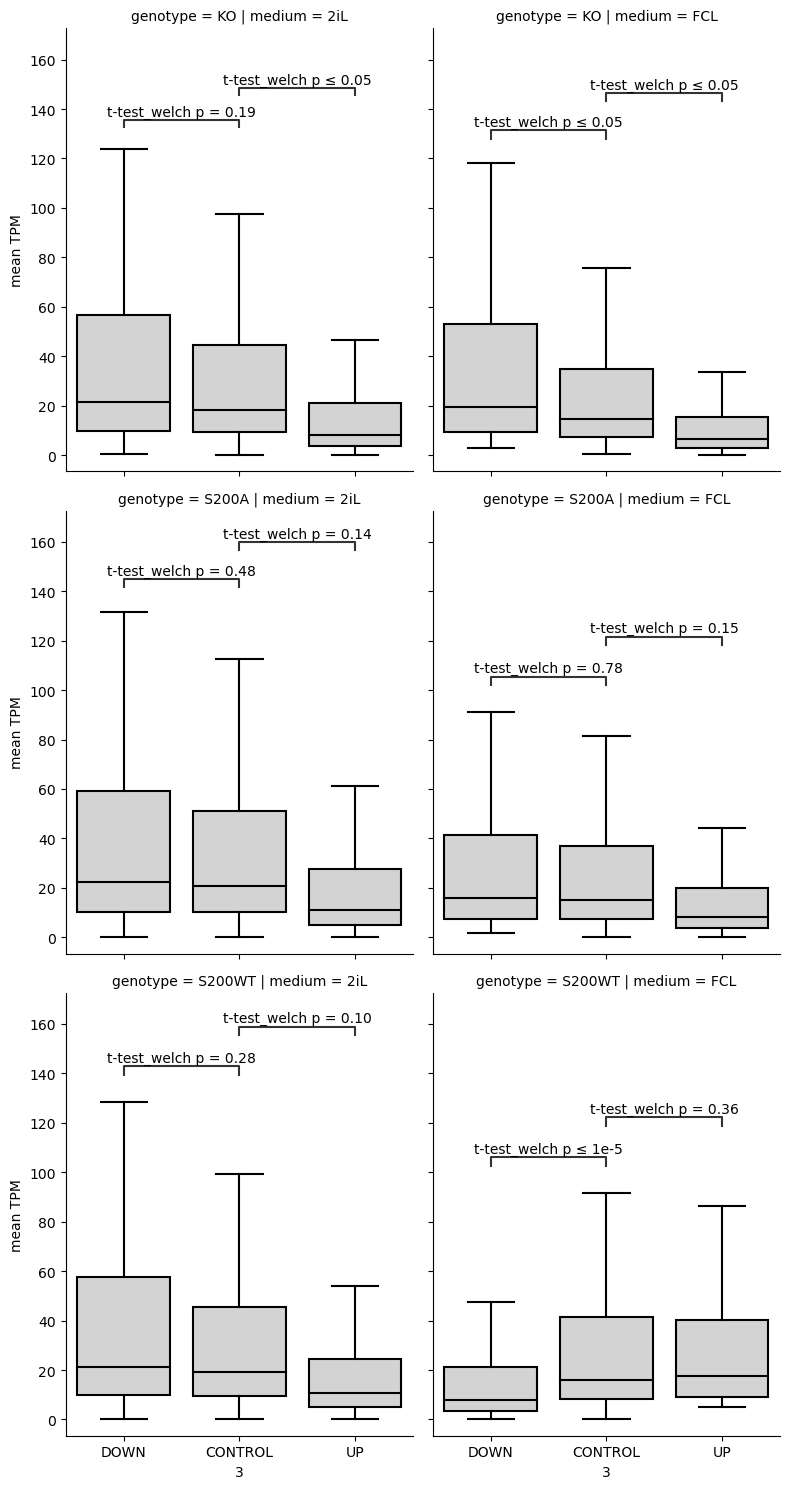

In [13]:
PROPS = {
    'boxprops':{'facecolor':'lightgrey', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}

g = sns.catplot(
    data=dfQuantseq, x=3, y='mean TPM', row='genotype', col='medium', kind='box',
    showfliers=False, aspect=.8, order=['DOWN', 'CONTROL', 'UP'], **PROPS
)


pairs = [('DOWN', 'CONTROL'), ('CONTROL', 'UP')]
for id, ax in g.axes_dict.items():
    print(id)
    # subset the table otherwise the stats were calculated on the whole dataset
    annot = Annotator(
        ax, pairs,
        data=dfQuantseq.loc[(dfQuantseq['genotype']==id[0]) & (dfQuantseq['medium']==id[1]),:],
        x=3,  y='mean TPM', order=['DOWN', 'CONTROL', 'UP'],
        )
    annot.configure(test='t-test_welch', text_format='simple', loc='inside')
    _, corrected_results = annot.apply_and_annotate()


g.savefig(f'{outpath}/GeneLevelTPMs_nofliers.pdf', bbox_inches='tight')